# Defi Llama TVL Project

### Import Libraries

In [2]:
import requests
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.ticker import FuncFormatter
from datetime import datetime
plt.style.use('ggplot')

### Reused Python Code

In [9]:
#Functions of use
def millions_formatter(x, pos):
    return f'${x / 1000000000} B'

## TVL Snapshot Analysis 

### Read in Protocol current TVL, Changes to TVL and basic information

API Documentation https://docs.llama.fi/api

The protocols_list.csv and chainlink_users_list.csv are pre filtered lists as per the specifications in the project. The code for the filtering can be found in archive.

In [3]:
# get protocol tvl 
response = requests.get("https://api.llama.fi/protocols")
output = response.json()

# market dataframe
df_market = pd.DataFrame(output)
market_list = pd.read_csv("protocols_list.csv")
df_market = df_market[df_market['slug'].isin(market_list['slug'])]
df_market = df_market[['chain', 'slug', 'category', 'tvl', 'change_1h', 'change_1d', 'change_7d', 'mcap']]

# chainlink dataframe
df_chainlink = pd.DataFrame(output)
chainlink_list = pd.read_csv("chainlink_users_list.csv")
df_chainlink = df_chainlink[df_chainlink['slug'].isin(chainlink_list['slug'])]
df_chainlink = df_chainlink[['chain', 'slug', 'category', 'tvl', 'change_1h', 'change_1d', 'change_7d', 'mcap']]

### Minor preprocessing to deal with NaN and 0 values

Depending on the analysis, the values may either have the NaN values replaced with 0 or filered out.
I.e. in the case of the tvl by category, chain and the net percentage replacing NaN values with 0 is fine as those values would have a weight of 0 in the aggregation/filter
However with the TVL/Marketcap metric, replacing market caps with 0 would give a heavy weighting to the tvl thus NaN values are filtered out instead. 

In [4]:
df_market = df_market[df_market['chain'].notna()]
df_market_og = df_market[df_market['category'].notna()]
df_chainlink = df_chainlink[df_chainlink['chain'].notna()]
df_chainlink_og = df_chainlink[df_chainlink['category'].notna()]

df_chainlink = df_chainlink_og.fillna(0) 
df_market = df_market_og.fillna(0) 

### Grouping data by Category and Chain 
We are looking at number of protocols by category and chain as well as net change and tvl sum by category and chain. 
Here we also calculate a tvl weighted change (not super accurate but better than aggregating net change or taking a simple average).

In [5]:
# get count statistics by chain
df_market_chain_count = df_market.groupby(['chain']).size().reset_index(name='Market').set_index('chain')
df_chainlink_chain_count = df_chainlink.groupby(['chain']).size().reset_index(name='Chainlink').set_index('chain')

# get sum tvl statistics by chain
df_market['net_change_1h'] = (df_market['change_1h']*df_market['tvl'])/df_market.groupby('chain')['tvl'].transform('sum')
df_market['net_change_1d'] = (df_market['change_1d']*df_market['tvl'])/df_market.groupby('chain')['tvl'].transform('sum')
df_market['net_change_7d'] = (df_market['change_7d']*df_market['tvl'])/df_market.groupby('chain')['tvl'].transform('sum')
df_market_chain_sum = df_market.groupby(['chain']).sum().reset_index().set_index('chain')
df_market_chain_sum.drop('change_1h', axis=1, inplace=True)
df_market_chain_sum.drop('change_1d', axis=1, inplace=True)
df_market_chain_sum.drop('change_7d', axis=1, inplace=True)
df_market_chain_sum.columns = ['tvl', 'mcap', 'net_change_1h', 'net_change_1d', 'net_change_7d']
df_chainlink['net_change_1h'] = df_chainlink['change_1h']*df_chainlink['tvl']/df_chainlink.groupby('chain')['tvl'].transform('sum')
df_chainlink['net_change_1d'] = df_chainlink['change_1d']*df_chainlink['tvl']/df_chainlink.groupby('chain')['tvl'].transform('sum')
df_chainlink['net_change_7d'] = df_chainlink['change_7d']*df_chainlink['tvl']/df_chainlink.groupby('chain')['tvl'].transform('sum')
df_chainlink_chain_sum = df_chainlink.groupby(['chain']).sum().reset_index().set_index('chain')
df_chainlink_chain_sum.drop('change_1h', axis=1, inplace=True)
df_chainlink_chain_sum.drop('change_1d', axis=1, inplace=True)
df_chainlink_chain_sum.drop('change_7d', axis=1, inplace=True)
df_chainlink_chain_sum.columns = ['tvl', 'mcap', 'net_change_1h', 'net_change_1d', 'net_change_7d']

# get count statistics by category
df_market_category_count = df_market.groupby(['category']).size().reset_index(name='Market').set_index('category')
df_chainlink_category_count = df_chainlink.groupby(['category']).size().reset_index(name='Chainlink').set_index('category')

# get sum tvl statistics by category
df_market['net_change_1h'] = (df_market['change_1h']*df_market['tvl'])/df_market.groupby('category')['tvl'].transform('sum')
df_market['net_change_1d'] = (df_market['change_1d']*df_market['tvl'])/df_market.groupby('category')['tvl'].transform('sum')
df_market['net_change_7d'] = (df_market['change_7d']*df_market['tvl'])/df_market.groupby('category')['tvl'].transform('sum')
df_market_category_sum = df_market.groupby(['category']).sum().reset_index().set_index('category')
df_market_category_sum.drop('change_1h', axis=1, inplace=True)
df_market_category_sum.drop('change_1d', axis=1, inplace=True)
df_market_category_sum.drop('change_7d', axis=1, inplace=True)
df_market_category_sum.columns = ['tvl', 'mcap', 'net_change_1h', 'net_change_1d', 'net_change_7d']
df_chainlink['net_change_1h'] = (df_chainlink['change_1h']*df_chainlink['tvl'])/df_chainlink.groupby('category')['tvl'].transform('sum')
df_chainlink['net_change_1d'] = (df_chainlink['change_1d']*df_chainlink['tvl'])/df_chainlink.groupby('category')['tvl'].transform('sum')
df_chainlink['net_change_7d'] = (df_chainlink['change_7d']*df_chainlink['tvl'])/df_chainlink.groupby('category')['tvl'].transform('sum')
df_chainlink_category_sum = df_chainlink.groupby(['category']).sum().reset_index().set_index('category')
df_chainlink_category_sum.drop('change_1h', axis=1, inplace=True)
df_chainlink_category_sum.drop('change_1d', axis=1, inplace=True)
df_chainlink_category_sum.drop('change_7d', axis=1, inplace=True)
df_chainlink_category_sum.columns = ['tvl', 'mcap', 'net_change_1h', 'net_change_1d', 'net_change_7d']

### Number of protocols by category or chain
Note: We are only plotting the largest for each category for visualisation ease.

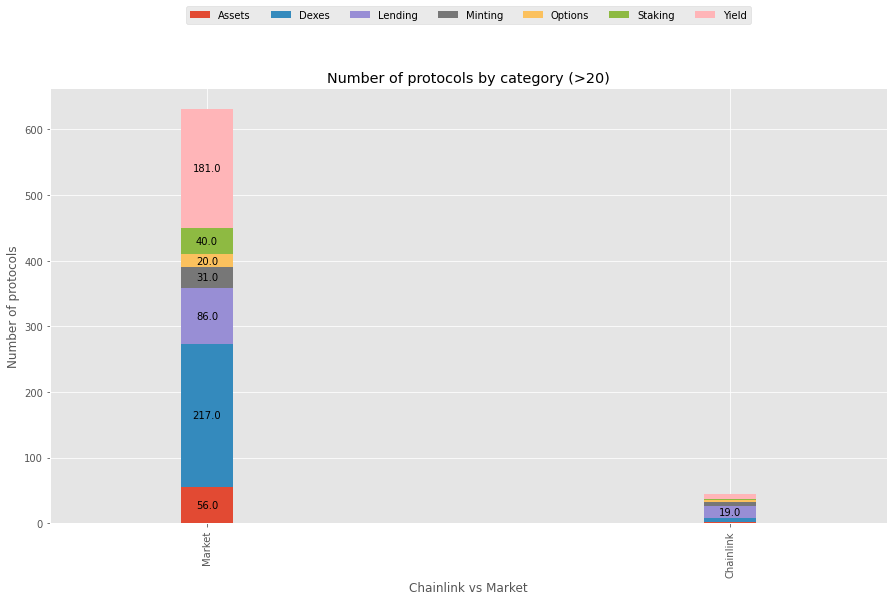

In [760]:
# plot count statistics by category
union = pd.concat([df_market_category_count.transpose(), df_chainlink_category_count.transpose()],axis=0)
union = union.loc[:, (union.sum() >= 20)] #too many categories, only plotting the largest
ax = union.plot.bar(stacked=True, width = 0.1, figsize= (15,8))
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 10 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
plt.xlabel('Chainlink vs Market')
plt.ylabel('Number of protocols')
plt.title('Number of protocols by category (>20)')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

#### Comments
We can see here that protocols that use Chainlink are still a minority in the total market, there is significantly more room for growth. We also see that Lending protocols make up the majority of protocols that use the Chainlink oraclen network. This makes sense as lending protocols require accurate price feeds in order to work out liquidation values and assets collateralisation ratios.

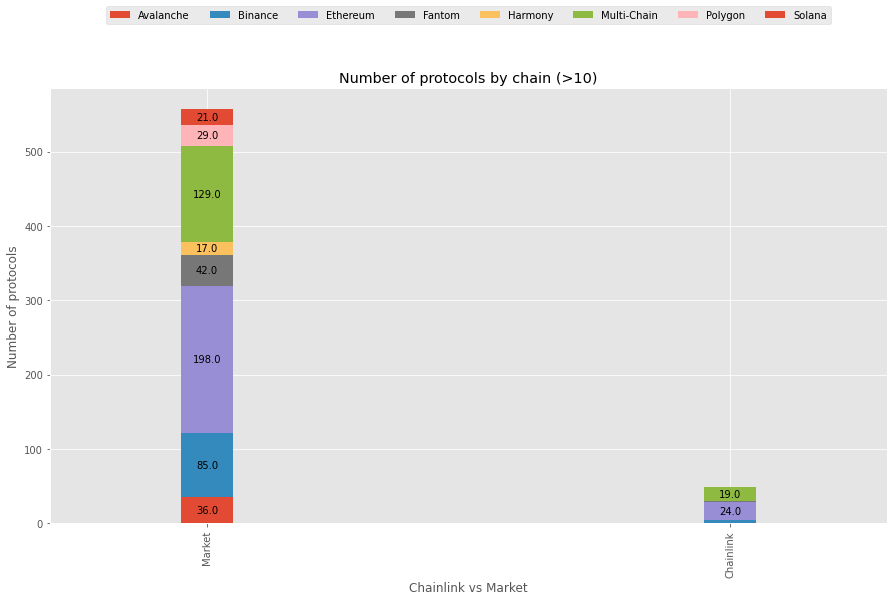

In [761]:
# plot count statistics by chain
union = pd.concat([df_market_chain_count.transpose(), df_chainlink_chain_count.transpose()],axis=0)
union = union.loc[:, (union.sum() >= 15)] #too many categories, only plotting the largest
ax = union.plot.bar(stacked=True, width = 0.1, figsize= (15,8))
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 10 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
plt.xlabel('Chainlink vs Market')
plt.ylabel('Number of protocols')
plt.title('Number of protocols by chain (>10)')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

#### Comments
The chains that majority of protocols that use Chainlink are Ethereum and Multi-Chain.

### Total TVL by Category or Chain
Note: We are only plotting the largest for each category for visualisation ease.

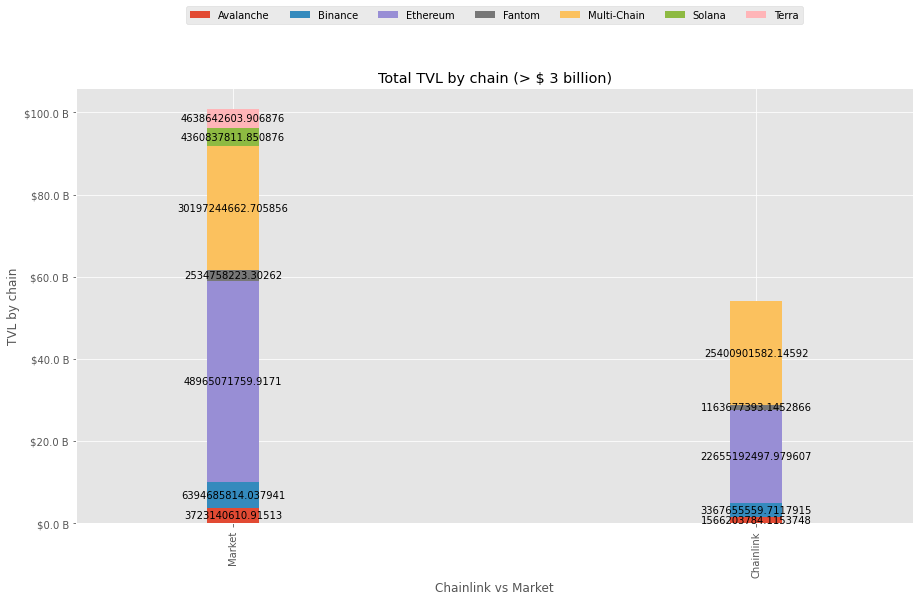

In [765]:
# plot sum statistics by chain
union = pd.concat([df_market_chain_sum[['tvl']].transpose(), df_chainlink_chain_sum[[ 'tvl']].transpose()],axis=0)
union = union.loc[:, (union.sum() >= 3000000000)] #too many categories, only plotting the largest
union.index = ['Market', 'Chainlink']
ax = union.plot.bar(stacked=True, width = 0.1, figsize= (15,8))
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 10 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
plt.xlabel('Chainlink vs Market')
plt.ylabel('TVL by chain')
plt.title('Total TVL by chain (> $ 3 billion)')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

#### Comments
The disparity between Chainlink and the total market is much smaller when comparing TVL as opposed to number of protocols. 
Larger protocols that capture the most value are users of Chainlink and greatly value the security of the oracle network for data feeds. Majority of the TVL for Chainlink using protocols is on Ethereum and Multi-Chain (with multi-chain the domain of large protocols). Relative to the market Chainlink has captured approximately 50% of the market TVL for the largest chains.

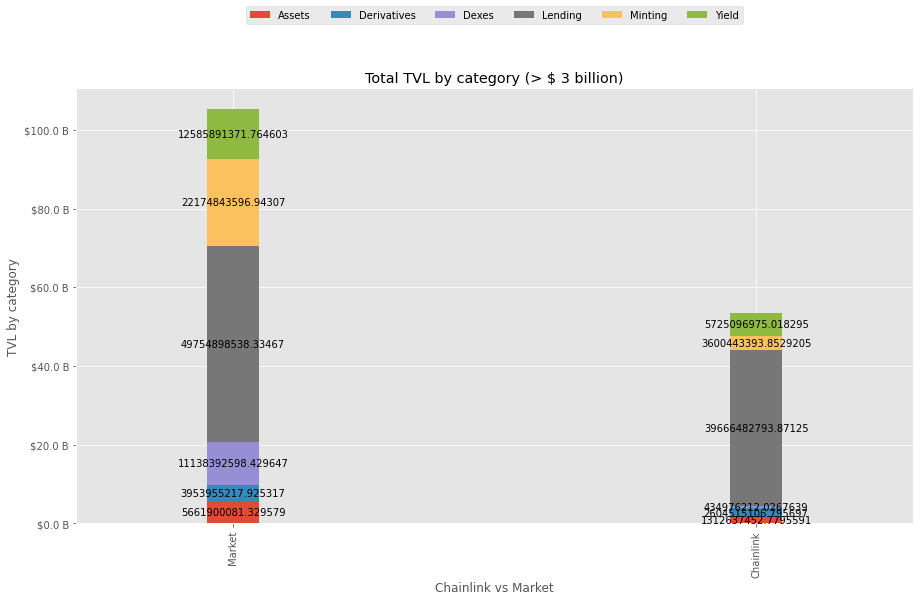

In [766]:
# plot sum statistics by category
union = pd.concat([df_market_category_sum[['tvl']].transpose(), df_chainlink_category_sum[['tvl']].transpose()],axis=0)
union = union.loc[:, (union.sum() >= 3000000000)] #too many categories, only plotting the largest
union.index = ['Market', 'Chainlink']
ax = union.plot.bar(stacked=True, width = 0.1, figsize= (15,8))
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 10 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
plt.xlabel('Chainlink vs Market')
plt.ylabel('TVL by category')
plt.title('Total TVL by category (> $ 3 billion)')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

#### Comments
In line with the number of protocols analysis, we see that majority of the TVL for Chainlink using protocols is in Lending.

### Total TVL Chainlink vs Rest of Market

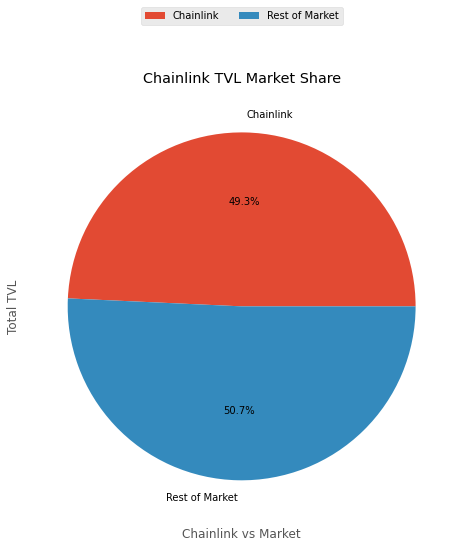

In [14]:
# plot tvl captured 
df_chainlink_total_sum = df_chainlink_chain_sum.sum(axis=0).reset_index(name='Chainlink').transpose()
df_chainlink_total_sum.columns = df_chainlink_total_sum.iloc[0]
df_chainlink_total_sum = df_chainlink_total_sum.iloc[1:,:]
df_market_total_sum = df_market_chain_sum.sum(axis=0).reset_index(name='Market').transpose()
df_market_total_sum.columns = df_market_total_sum.iloc[0]
df_market_total_sum = df_market_total_sum.iloc[1:,:]
union = pd.concat([df_market_total_sum['tvl'], df_chainlink_total_sum['tvl']],axis=0)
union.loc['Rest of Market'] = union.loc['Market'] - union.loc['Chainlink']
union = union.drop('Market')

ax = union.plot.pie(subplots=True, figsize= (15,8), autopct='%1.1f%%')
plt.xlabel('Chainlink vs Market')
plt.ylabel('Total TVL')
plt.title('Chainlink TVL Market Share')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

#### Comments
Overall as seen in the above stacked chart, Chainlink captures roughly half the TVL of the total market which equates to a third of the total TVL in the market (as per the DefiLlama API capture).

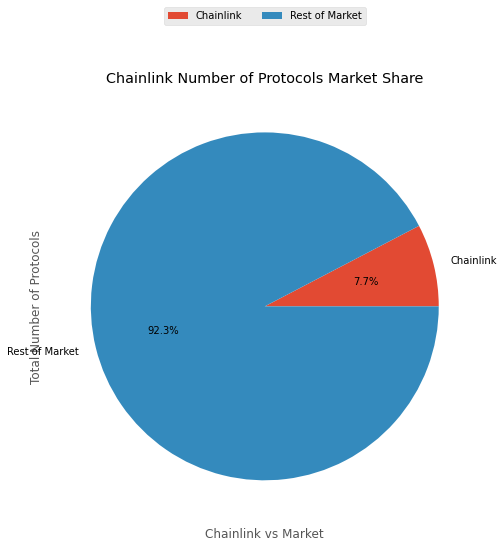

In [16]:
# plot number of protocols captured 
df_chainlink_total_count = df_chainlink_chain_count.sum(axis=0).reset_index(name='Chainlink').transpose()
df_chainlink_total_count.columns = df_chainlink_total_count.iloc[0]
df_chainlink_total_count = df_chainlink_total_count.iloc[1:,:]
df_chainlink_total_count.columns = ['count']
df_market_total_count = df_market_chain_count.sum(axis=0).reset_index(name='Market').transpose()
df_market_total_count.columns = df_market_total_count.iloc[0]
df_market_total_count = df_market_total_count.iloc[1:,:]
df_market_total_count.columns = ['count']
union = pd.concat([df_market_total_count, df_chainlink_total_count],axis=0)
union.loc['Rest of Market'] = union.loc['Market'] - union.loc['Chainlink']
union = union.drop('Market')

ax = union.plot.pie(subplots=True, figsize= (15,8), autopct='%1.1f%%')
plt.xlabel('Chainlink vs Market')
plt.ylabel('Total Number of Protocols')
plt.title('Chainlink Number of Protocols Market Share')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

### Net Change of TVL over 1hr, 1d, 7d by Catgeory and Chain

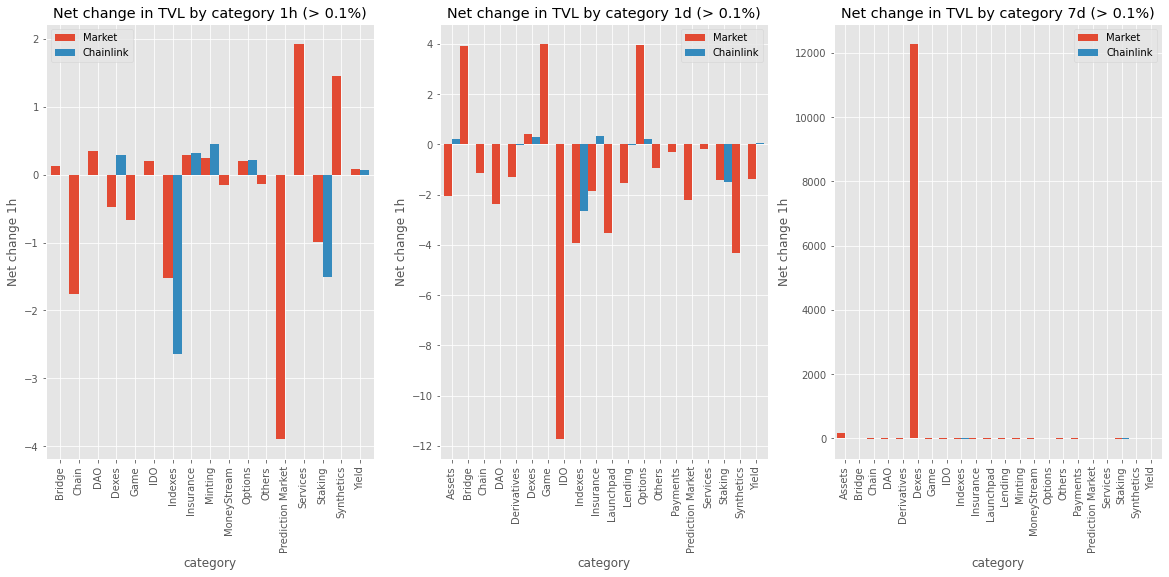

In [769]:
# Net change 1hr, 1d, 7d by category
union1 = pd.concat([df_market_category_sum[['net_change_1h']].transpose(), df_chainlink_category_sum[['net_change_1h']].transpose()],axis=0)
union1 = union1.loc[:, (union1.sum().abs() >= 0.1)] #too many categories, only plotting the largest percentage shifts
union1.index = ['Market', 'Chainlink']
union1 = union1.transpose()

union2 = pd.concat([df_market_category_sum[['net_change_1d']].transpose(), df_chainlink_category_sum[['net_change_1h']].transpose()],axis=0)
union2 = union2.loc[:, (union2.sum().abs() >= 0.1)] #too many categories, only plotting the largest percentage shifts
union2.index = ['Market', 'Chainlink']
union2 = union2.transpose()

union3 = pd.concat([df_market_category_sum[['net_change_7d']].transpose(), df_chainlink_category_sum[['net_change_1h']].transpose()],axis=0)
union3 = union3.loc[:, (union3.sum().abs() >= 0.1)] #too many categories, only plotting the largest percentage shifts
union3.index = ['Market', 'Chainlink']
union3 = union3.transpose()

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex=False, sharey= False, figsize= (20,8))
ax1 = union1.plot.bar(width = 1, ax=ax1)
union2.plot.bar(width = 1, ax=ax2)
union3.plot.bar(width = 1, ax=ax3)
ax1.set_ylabel('Net change 1h')
ax2.set_ylabel('Net change 1h')
ax3.set_ylabel('Net change 1h')
ax1.set_title('Net change in TVL by category 1h (> 0.1%)')
ax2.set_title('Net change in TVL by category 1d (> 0.1%)')
ax3.set_title('Net change in TVL by category 7d (> 0.1%)')
plt.show()

#### Comments
Dexes show the greatest net change (positive change here) in TVL which is not surprising with the liquidity mining incentives during the market bullrun. These changes are weighted, so this points to an entire movement in Dexes.

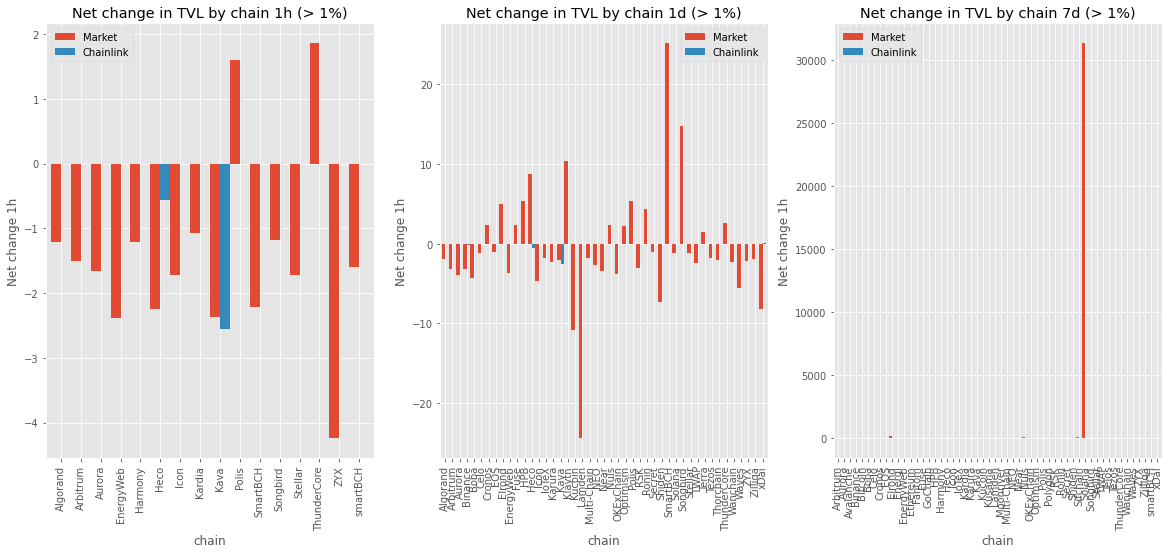

In [770]:
# Net change 1hr by chain
union1 = pd.concat([df_market_chain_sum[['net_change_1h']].transpose(), df_chainlink_chain_sum[['net_change_1h']].transpose()],axis=0)
union1 = union1.loc[:, (union1.sum().abs() >= 1)] #too many categories, only plotting the largest percentage shifts
union1.index = ['Market', 'Chainlink']
union1 = union1.transpose()

union2 = pd.concat([df_market_chain_sum[['net_change_1d']].transpose(), df_chainlink_chain_sum[['net_change_1h']].transpose()],axis=0)
union2 = union2.loc[:, (union2.sum().abs() >= 1)] #too many categories, only plotting the largest percentage shifts
union2.index = ['Market', 'Chainlink']
union2 = union2.transpose()

union3 = pd.concat([df_market_chain_sum[['net_change_7d']].transpose(), df_chainlink_chain_sum[['net_change_1h']].transpose()],axis=0)
union3 = union3.loc[:, (union3.sum().abs() >= 1)] #too many categories, only plotting the largest percentage shifts
union3.index = ['Market', 'Chainlink']
union3 = union3.transpose()

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex=False, sharey= False, figsize= (20,8))
ax1 = union1.plot.bar(width = 1, ax=ax1)
union2.plot.bar(width = 1, ax=ax2)
union3.plot.bar(width = 1, ax=ax3)
ax1.set_ylabel('Net change 1h')
ax2.set_ylabel('Net change 1h')
ax3.set_ylabel('Net change 1h')
ax1.set_title('Net change in TVL by chain 1h (> 1%)')
ax2.set_title('Net change in TVL by chain 1d (> 1%)')
ax3.set_title('Net change in TVL by chain 7d (> 1%)')
plt.show()

#### Comments
On inspection, Solana is the outlier with 23239% change in the past 7days, the next largest absolute net change is 129% hence to gauge a better picture of the net change over 7 days feel free to filter out where chain = 'Solana' and rerun the graph above

### TVL/Market Cap by Category and Chain
TVL/Market Cap is a very popular metric uses to evaluate how "worth it" a defi protocol may be since TVL is "true" value as it refers to the locked assets in the stake/pools whereas market cap is the value of the protocol as decided by market forces.

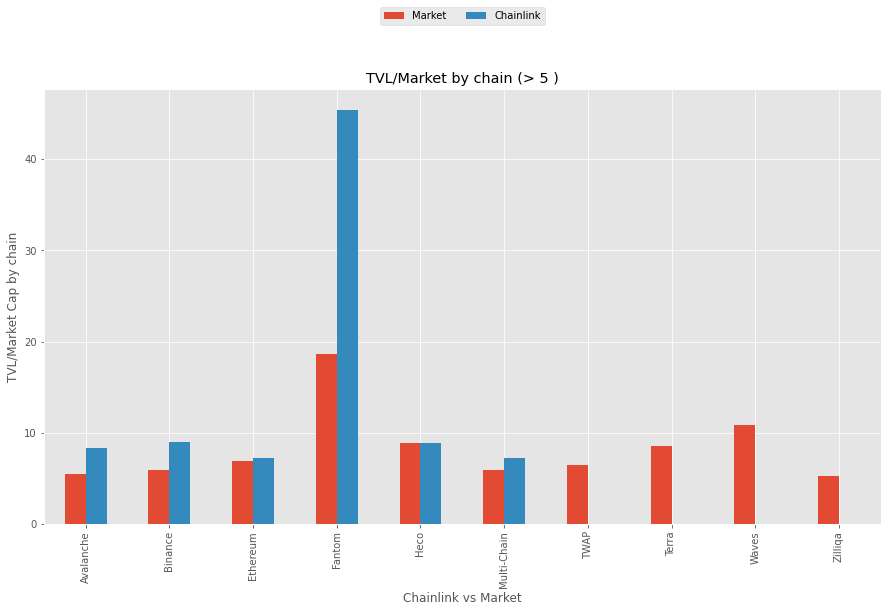

In [771]:
# tvl market cap analysis uses the og data set without the 0 replacing na
df_market_market_cap =  df_market_og.dropna()
df_chainlink_market_cap =  df_chainlink_og.dropna()
df_market_market_cap = df_market_market_cap[df_market_market_cap['mcap'] != 0] 
df_chainlink_market_cap = df_chainlink_market_cap[df_chainlink_market_cap['mcap'] != 0] 
df_market_market_cap['tvl_over_mcap'] = df_market_market_cap['tvl']/df_market_market_cap['mcap']
df_chainlink_market_cap['tvl_over_mcap'] = df_chainlink_market_cap['tvl']/df_chainlink_market_cap['mcap']

df_market_average_market_cap = df_market_market_cap.groupby(['chain'])['tvl_over_mcap'].mean().reset_index().set_index('chain')
df_chainlink_average_market_cap = df_chainlink_market_cap.groupby(['chain'])['tvl_over_mcap'].mean().reset_index().set_index('chain')
df_market_average_market_cap.columns = ['average_tvl_over_mcap']
df_chainlink_average_market_cap.columns = ['average_tvl_over_mcap']

union = pd.concat([df_market_average_market_cap[['average_tvl_over_mcap']].transpose(), df_chainlink_average_market_cap[['average_tvl_over_mcap']].transpose()],axis=0)
union = union.loc[:, (union.sum() >= 5)] #too many categories, only plotting the largest percentage shifts
union.index = ['Market', 'Chainlink']
union = union.transpose()

ax = union.plot.bar(width = 0.5, figsize= (15,8))
plt.xlabel('Chainlink vs Market')
plt.ylabel('TVL/Market Cap by chain')
plt.title('TVL/Market by chain (> 5 )')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

#### Comments
Interestingly, Chainlink protocols show a better average TVL/Market Cap across the chains (Chainlink value?) 

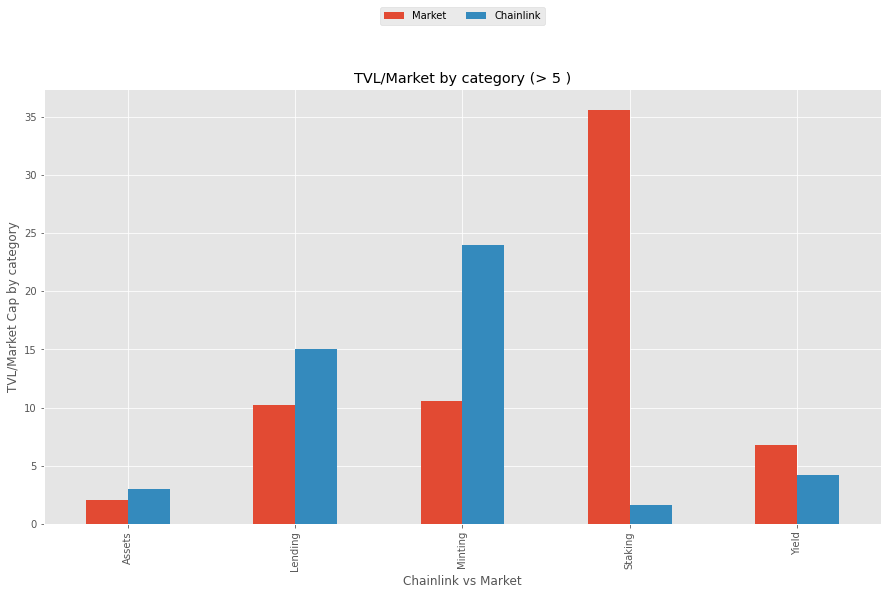

In [772]:
df_market_average_market_cap = df_market_market_cap.groupby(['category'])['tvl_over_mcap'].mean().reset_index().set_index('category')
df_chainlink_average_market_cap = df_chainlink_market_cap.groupby(['category'])['tvl_over_mcap'].mean().reset_index().set_index('category')
df_market_average_market_cap.columns = ['average_tvl_over_mcap']
df_chainlink_average_market_cap.columns = ['average_tvl_over_mcap']

union = pd.concat([df_market_average_market_cap[['average_tvl_over_mcap']].transpose(), df_chainlink_average_market_cap[['average_tvl_over_mcap']].transpose()],axis=0)
union = union.loc[:, (union.sum() >= 5)] #too many categories, only plotting the largest percentage shifts
union.index = ['Market', 'Chainlink']
union = union.transpose()

ax = union.plot.bar(width = 0.5, figsize= (15,8))
plt.xlabel('Chainlink vs Market')
plt.ylabel('TVL/Market Cap by category')
plt.title('TVL/Market by category (> 5 )')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

#### Comments
Interestingly Chainlink using protocols that are categorised as stakers show a very low TVL/Market cap relative to the rest of the market.

## TVL over time analysis
The following analysis collects the TVL overtime for protocols and analyses the trend. The following cell takes around 30minutes to run to collect all the historical values across the entire market protocols and the chainlink protocols. The loop works to go through all the protocols listed, collect the chains for each protocol and find the tvl for each chain then store it in a dataframe. 

In [7]:
# get historical with basic data
df_protocols = pd.read_csv("protocols_list.csv")
protocols = df_protocols['slug'].values.tolist()
protocol_tvl = []
for protocol in protocols:
    response = requests.get(f"https://api.llama.fi/protocol/{protocol}")
    output = response.json()
    chains = output.get("chains")
    #category = output.get("category")
    for chain in chains:
        chain_tvl = output.get("chainTvls").get(f"{chain}").get("tvl")
        df_chain_tvl = pd.DataFrame(chain_tvl)
        df_chain_tvl['chain'] = chain
        df_chain_tvl['protocol'] = protocol
        #df_chain_tvl['category'] = category
        protocol_tvl.append(df_chain_tvl)

market_protocols = pd.concat(protocol_tvl)

df_chainlink_protocols = pd.read_csv("chainlink_users_list.csv")
protocols = df_chainlink_protocols['slug'].values.tolist()
protocol_tvl = []
for protocol in protocols:
    response = requests.get(f"https://api.llama.fi/protocol/{protocol}")
    output = response.json()
    chains = output.get("chains")
    #category = output.get("category")
    for chain in chains:
        chain_tvl = output.get("chainTvls").get(f"{chain}").get("tvl")
        df_chain_tvl = pd.DataFrame(chain_tvl)
        df_chain_tvl['chain'] = chain
        df_chain_tvl['protocol'] = protocol
        #df_chain_tvl['category'] = category
        protocol_tvl.append(df_chain_tvl)

chainlink_protocols = pd.concat(protocol_tvl)

### TVL over time by Chain
Since the TVL is recorded multiple times in one day, we take the max value for the day.

In [30]:
# chain analysis
market_protocols_chain = market_protocols.groupby(['date', 'chain']).sum('totalLiquidityUSD').reset_index()
chainlink_protocols_chain = chainlink_protocols.groupby(['date', 'chain']).sum('totalLiquidityUSD').reset_index()
## market 
market_protocols_chain['date'] = market_protocols_chain['date'].apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))
market_protocols_chain = market_protocols_chain.groupby(['date', 'chain']).max('totalLiquidityUSD').reset_index()
## chainlink
chainlink_protocols_chain['date'] = chainlink_protocols_chain['date'].apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))
chainlink_protocols_chain = chainlink_protocols_chain.groupby(['date', 'chain']).max('totalLiquidityUSD').reset_index()

## filter out todays date
todays_date = datetime.today().strftime('%Y-%m-%d')
market_protocols_chain =  market_protocols_chain[market_protocols_chain['date'] != todays_date]
chainlink_protocols_chain =  chainlink_protocols_chain[chainlink_protocols_chain['date'] != todays_date]

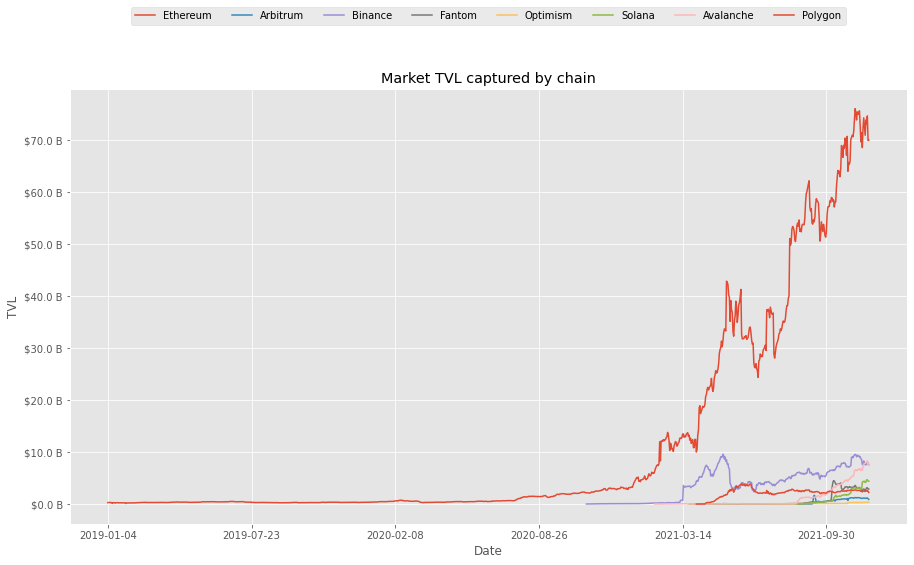

In [32]:
#Overall TVL Trend by chain
## focusing on major chains
market_protocols_chain_pivot = market_protocols_chain.pivot_table(index='date',columns='chain',values='totalLiquidityUSD',aggfunc='max')
ax = market_protocols_chain_pivot.plot.line(y = ['Ethereum', 'Arbitrum', 'Binance', 'Fantom', 'Optimism', 'Solana', 'Avalanche', 'Polygon'], figsize = (15,8))
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.xlabel('Date')
plt.ylabel('TVL')
plt.title('Market TVL captured by chain')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

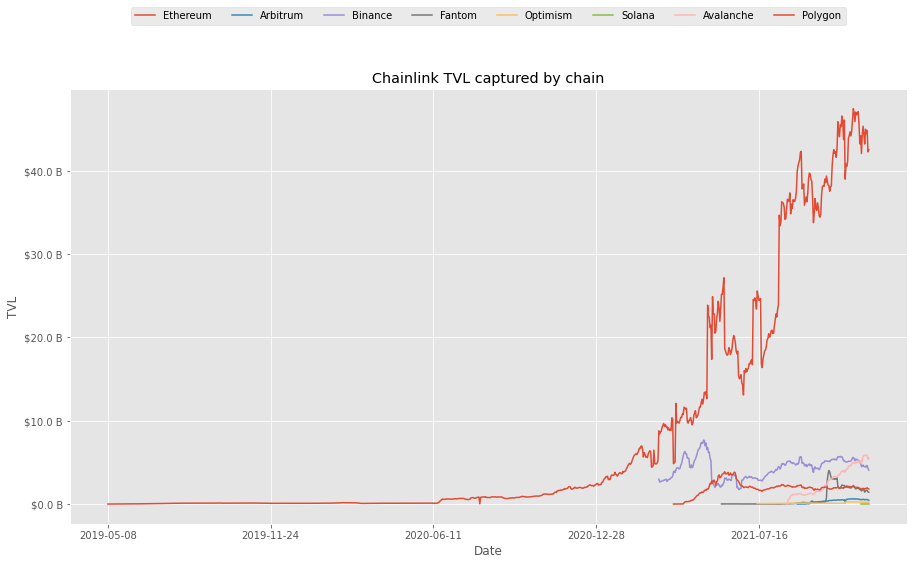

In [33]:
#Overall TVL Trend by chain
## focusing on major chains
chainlink_protocols_chain_pivot = chainlink_protocols_chain.pivot_table(index='date',columns='chain',values='totalLiquidityUSD',aggfunc='max')
ax = chainlink_protocols_chain_pivot.plot.line(y = ['Ethereum', 'Arbitrum', 'Binance', 'Fantom', 'Optimism', 'Solana', 'Avalanche', 'Polygon'], figsize = (15,8))
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.xlabel('Date')
plt.ylabel('TVL')
plt.title('Chainlink TVL captured by chain')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

#### Comments
The protocols that use Chainlink follow a similar trend pattern to the rest of the market. There was a very significant dip in TVL on the Ethereum chain on the last date. This is due to the TVL collection not completing. Will need to verify this against an external source. 

### TVL over time by Category

In [36]:
merge_market = pd.merge(market_protocols, df_market, left_on='protocol', right_on='slug')
market_category = merge_market[['date', 'totalLiquidityUSD', 'category']]
merge_chainlink = pd.merge(market_protocols, df_chainlink, left_on='protocol', right_on='slug')
chainlink_category = merge_chainlink[['date', 'totalLiquidityUSD', 'category']]

# category analysis
market_protocols_category = market_category.groupby(['date', 'category']).sum('totalLiquidityUSD').reset_index()
chainlink_protocols_category = chainlink_category.groupby(['date', 'category']).sum('totalLiquidityUSD').reset_index()
## market 
market_protocols_category['date'] = market_protocols_category['date'].apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))
market_protocols_category = market_protocols_category.groupby(['date', 'category']).max('totalLiquidityUSD').reset_index()
## chainlink
chainlink_protocols_category['date'] = chainlink_protocols_category['date'].apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))
chainlink_protocols_category = chainlink_protocols_category.groupby(['date', 'category']).max('totalLiquidityUSD').reset_index()

## remove todays date
todays_date = datetime.today().strftime('%Y-%m-%d')
market_protocols_category =  market_protocols_category[market_protocols_category['date'] != todays_date]
chainlink_protocols_category =  chainlink_protocols_category[chainlink_protocols_category['date'] != todays_date]

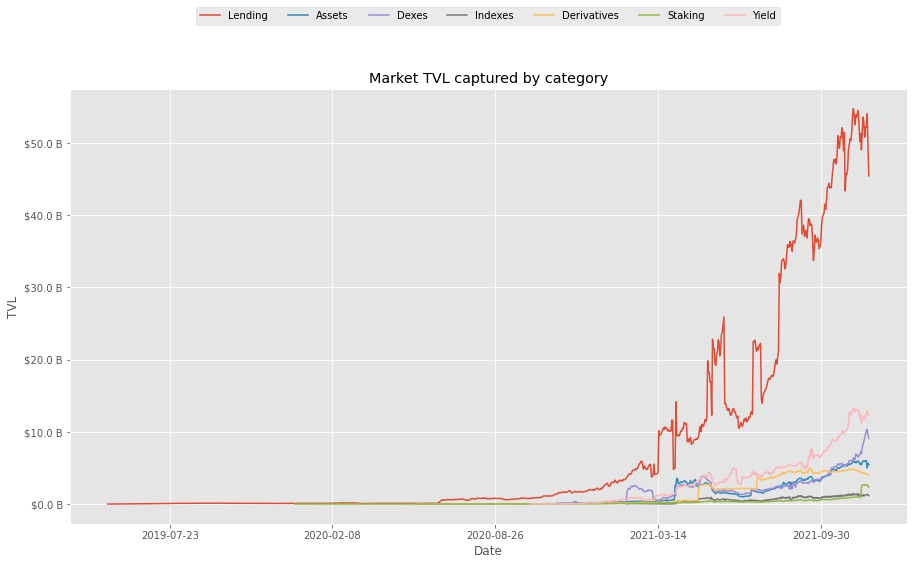

In [37]:
#Market TVL Trend by category
## focusing on major category
market_protocols_category_pivot = market_protocols_category.pivot_table(index='date',columns='category',values='totalLiquidityUSD',aggfunc='max')
ax = market_protocols_category_pivot.plot.line(y=['Lending', 'Assets', 'Dexes', 'Indexes', 'Derivatives', 'Staking', 'Yield'], figsize = (15,8))
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.xlabel('Date')
plt.ylabel('TVL')
plt.title('Market TVL captured by category')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

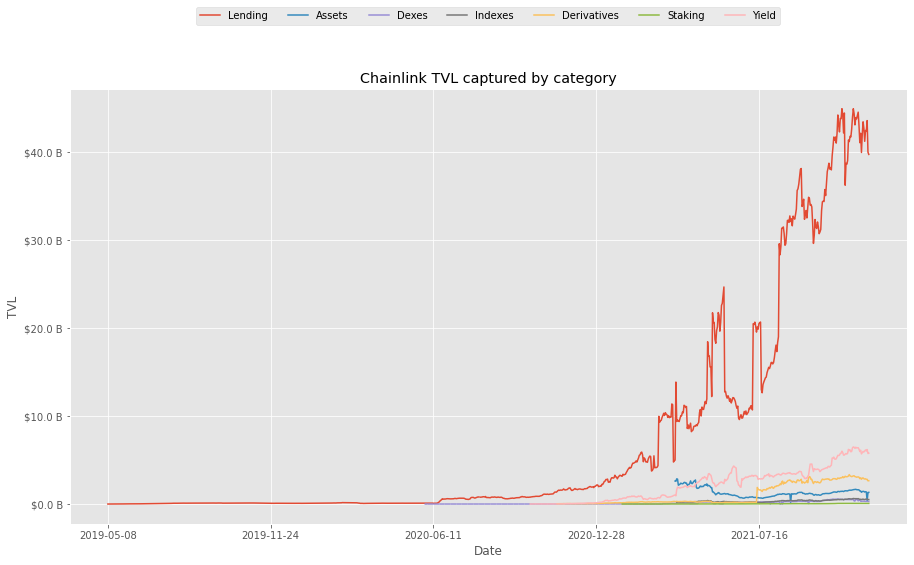

In [38]:
#Chainlink TVL Trend by category
## focusing on major category
chainlink_protocols_category_pivot = chainlink_protocols_category.pivot_table(index='date',columns='category',values='totalLiquidityUSD',aggfunc='max')
ax = chainlink_protocols_category_pivot.plot.line(y=['Lending', 'Assets', 'Dexes', 'Indexes', 'Derivatives', 'Staking', 'Yield'], figsize = (15,8))
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.xlabel('Date')
plt.ylabel('TVL')
plt.title('Chainlink TVL captured by category')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

#### Comments
Likewise to the above TVL over chain, we see the similar pattern.

### Total TVL over time Chainlink vs Market

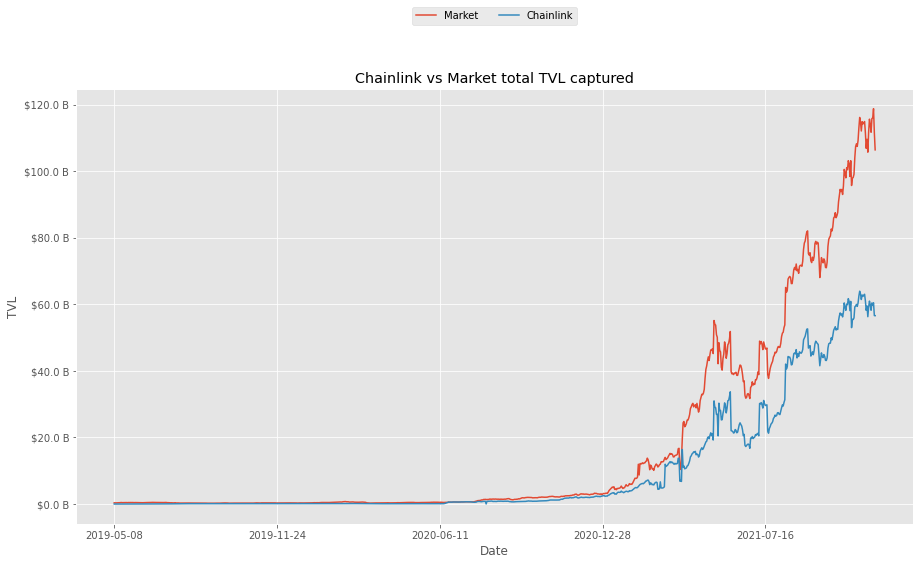

In [40]:
market_protocols_total = market_protocols.groupby(['date']).sum('totalLiquidityUSD').reset_index()
market_protocols_total['date'] = market_protocols_total['date'].apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))
market_protocols_total = market_protocols_total.groupby(['date']).max('totalLiquidityUSD').reset_index()
market_protocols_total['Market'] = market_protocols_total['totalLiquidityUSD']
market_protocols_total.drop('totalLiquidityUSD',axis=1, inplace=True)

chainlink_protocols_total = chainlink_protocols.groupby(['date']).sum('totalLiquidityUSD').reset_index()
chainlink_protocols_total['date'] = chainlink_protocols_total['date'].apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))
chainlink_protocols_total = chainlink_protocols_total.groupby(['date']).max('totalLiquidityUSD').reset_index()
chainlink_protocols_total['Chainlink'] = chainlink_protocols_total['totalLiquidityUSD']
chainlink_protocols_total.drop('totalLiquidityUSD',axis=1, inplace=True)

## remove todays date
todays_date = datetime.today().strftime('%Y-%m-%d')
market_protocols_total =  market_protocols_total[market_protocols_total['date'] != todays_date]
chainlink_protocols_total =  chainlink_protocols_total[chainlink_protocols_total['date'] != todays_date]

merge = pd.merge(market_protocols_total, chainlink_protocols_total, on=['date'])
merge = merge.set_index('date')

ax = merge.plot.line(figsize = (15,8))
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.xlabel('Date')
plt.ylabel('TVL')
plt.title('Chainlink vs Market total TVL captured')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

## Total TVL Chainlink/Market

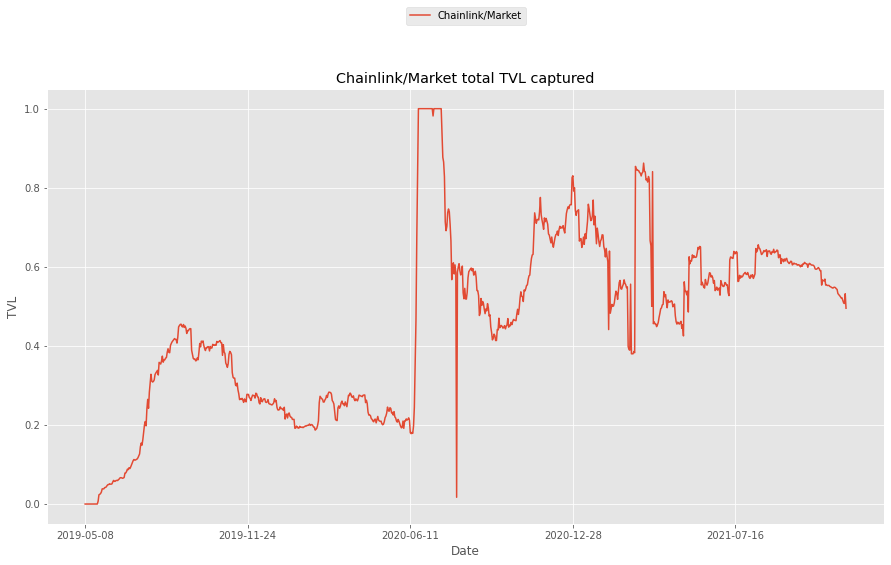

In [41]:
market_protocols_total = market_protocols.groupby(['date']).sum('totalLiquidityUSD').reset_index()
market_protocols_total['date'] = market_protocols_total['date'].apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))
market_protocols_total = market_protocols_total.groupby(['date']).max('totalLiquidityUSD').reset_index()
market_protocols_total['Market'] = market_protocols_total['totalLiquidityUSD']
market_protocols_total.drop('totalLiquidityUSD',axis=1, inplace=True)

chainlink_protocols_total = chainlink_protocols.groupby(['date']).sum('totalLiquidityUSD').reset_index()
chainlink_protocols_total['date'] = chainlink_protocols_total['date'].apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))
chainlink_protocols_total = chainlink_protocols_total.groupby(['date']).max('totalLiquidityUSD').reset_index()
chainlink_protocols_total['Chainlink'] = chainlink_protocols_total['totalLiquidityUSD']
chainlink_protocols_total.drop('totalLiquidityUSD',axis=1, inplace=True)

merge = pd.merge(market_protocols_total, chainlink_protocols_total, on=['date'])
merge = merge.set_index('date')
merge['Chainlink/Market'] = merge['Chainlink']/merge['Market']

ax = merge.plot.line(y = ['Chainlink/Market'], figsize = (15,8))
plt.xlabel('Date')
plt.ylabel('TVL')
plt.title('Chainlink/Market total TVL captured')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()

#### Comments
Here we see that chainlink protocols has in recent times captured roughly between 50-60% of the market protocols in TVL  

### Total TVL on Ethereum over time Chainlink vs Market 

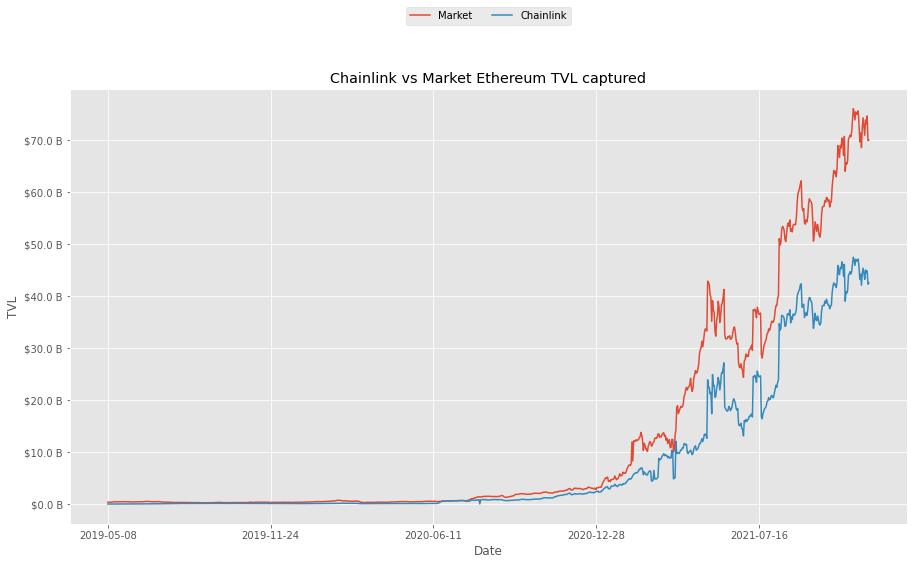

In [43]:
# Ethereum chain 
market_protocols_eth = market_protocols[market_protocols['chain']=='Ethereum'].groupby(['date']).sum('totalLiquidityUSD').reset_index()
market_protocols_eth['date'] = market_protocols_eth['date'].apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))
market_protocols_eth = market_protocols_eth.groupby(['date']).max('totalLiquidityUSD').reset_index()
market_protocols_eth['Market'] = market_protocols_eth['totalLiquidityUSD']
market_protocols_eth.drop('totalLiquidityUSD',axis=1, inplace=True)

chainlink_protocols_eth = chainlink_protocols[chainlink_protocols['chain']=='Ethereum'].groupby(['date']).sum('totalLiquidityUSD').reset_index()
chainlink_protocols_eth['date'] = chainlink_protocols_eth['date'].apply(lambda d: datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))
chainlink_protocols_eth = chainlink_protocols_eth.groupby(['date']).max('totalLiquidityUSD').reset_index()
chainlink_protocols_eth['Chainlink'] = chainlink_protocols_eth['totalLiquidityUSD']
chainlink_protocols_eth.drop('totalLiquidityUSD',axis=1, inplace=True)

## remove todays date
todays_date = datetime.today().strftime('%Y-%m-%d')
market_protocols_eth =  market_protocols_eth[market_protocols_eth['date'] != todays_date]
chainlink_protocols_eth =  chainlink_protocols_eth[chainlink_protocols_eth['date'] != todays_date]

merge = pd.merge(market_protocols_eth, chainlink_protocols_eth, on=['date'])
merge = merge.set_index('date')

ax = merge.plot.line(figsize = (15,8))
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.xlabel('Date')
plt.ylabel('TVL')
plt.title('Chainlink vs Market Ethereum TVL captured')
plt.legend( ncol=8 , loc = 'upper center', bbox_to_anchor=(0.5, 1.2))
plt.show()
